In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

import utils
import Model
import config


class ContinualLearningTrainer:
    def __init__(self, config):
        self.default_path = config.default_path
        self.classes = config.classes
        self.dataset = config.dataset
        self.info = config.Info

        self.train_ratio = 0.5
        self.set_epoch = 20
        self.set_batch_size = 256
        self.model_name = "Cont_L_Model"

        self.init_acc_all = []
        self.prev_acc_all = []
        self.trained_acc_all = []
        self.X_test_prev_all = []
        self.y_test_prev_all = []

    def init_stage(self, X_train, y_train, model):
        weights_task = [tf.identity(var) for var in model.trainable_variables]
        importance = [tf.zeros_like(var) for var in model.trainable_variables]
        batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(self.set_batch_size)

        for x_batch, y_batch in batch:
            with tf.GradientTape() as tape:
                preds = model(x_batch)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds)
            grads = tape.gradient(loss, model.trainable_variables)
            for i, grad in enumerate(grads):
                if grad is not None:
                    importance[i] += tf.square(grad)

        importance = [imp / len(batch) for imp in importance]
        return weights_task, importance

    def adaptation_stage(self, X_train, y_train, X_test, y_test, model, weights_prev_task, importance):
        lambda_ewc = 1000.0
        optimizer = tf.keras.optimizers.Adam()
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(self.set_batch_size)

        acc_init = model.evaluate(X_test, y_test, verbose=0)[1]

        for epoch in range(self.set_epoch):
            for step, (x_batch, y_batch) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    preds = model(x_batch, training=True)
                    loss = loss_fn(y_batch, preds)
                    for var, old_w, imp in zip(model.trainable_variables, weights_prev_task, importance):
                        loss += (lambda_ewc / 2) * tf.reduce_sum(imp * tf.square(var - old_w))
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

        acc_prev_data = model.evaluate(self.X_test_prev_all, self.y_test_prev_all, verbose=0)[1]
        acc_current_stage = model.evaluate(X_test, y_test, verbose=0)[1]

        return acc_init, acc_prev_data, acc_current_stage

    def run(self):
        for idx, session in enumerate(self.dataset):
            print(f"{'='*43}\nDataset {idx+1}/{len(self.dataset)} - Session {session}\n{'='*43}")
            path = os.path.join(self.default_path, session, 'raw/')

            feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
            X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=self.train_ratio)

            if idx == 0:
                model = Model.Original_model_V1(X_train.shape[1:])
                history, model = Model.Train_model(
                    model, X_train, y_train, X_test, y_test,
                    self.set_epoch, self.set_batch_size, self.model_name,
                    set_verbose=0, save_model_set=True
                )
                acc = model.evaluate(X_test, y_test, verbose=0)[1]
                self.init_acc_all, self.prev_acc_all, self.trained_acc_all = [0.2], [acc], [acc]
                self.X_test_prev_all, self.y_test_prev_all = X_test, y_test
            else:
                model = load_model(f'{self.model_name}.keras')
                weights_task, importance = self.init_stage(X_train, y_train, model)
                init, prev, current = self.adaptation_stage(
                    X_train, y_train, X_test, y_test, model,
                    weights_task, importance
                )
                self.init_acc_all.append(init)
                self.prev_acc_all.append(prev)
                self.trained_acc_all.append(current)
                self.X_test_prev_all = np.concatenate((self.X_test_prev_all, X_test), axis=0)
                self.y_test_prev_all = np.concatenate((self.y_test_prev_all, y_test), axis=0)
                del model

        return self.init_acc_all, self.trained_acc_all, self.prev_acc_all

    def plot_results(self, baseline_csv_path, baseline2_csv_path):
        baseline = pd.read_csv(baseline_csv_path)
        baseline2 = pd.read_csv(baseline2_csv_path)

        plt.figure(figsize=(15, 8))
        plt.title('Training from scratch every time', fontsize=15)
        plt.plot(self.info, self.init_acc_all, marker='o', label='Untrained model on current data', linestyle='--')
        plt.plot(self.info, self.prev_acc_all, marker='o', label='Model trained + tested on accumulated data')
        plt.plot(self.info, self.trained_acc_all, marker='o', label='Model trained + tested on current split')
        plt.plot(self.info, baseline['Accuracy'] / 100, marker='^', label='Baseline (first session only)', color='red', linestyle='--')
        plt.plot(self.info, baseline2['Accuracy'] / 100, marker='^', label='Baseline - v2 (first session only)', linestyle='--')

        plt.ylim([0, 1])
        plt.xlabel('Date (Sessions)')
        plt.ylabel('Test Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Dataset 1/26 - Session Exp_2025-05-27/E8331D05289A/
Start Training (total epochs: 20)...
Finish Training! (Model is saved)
Maximum training accuracy : 86.25%
Maximum validation accuracy : 92.88%
Dataset 2/26 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/26 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/26 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/26 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/26 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/26 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/26 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/26 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/26 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/26 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/26 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/26 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/26 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/26 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/26 - Session Exp_2025

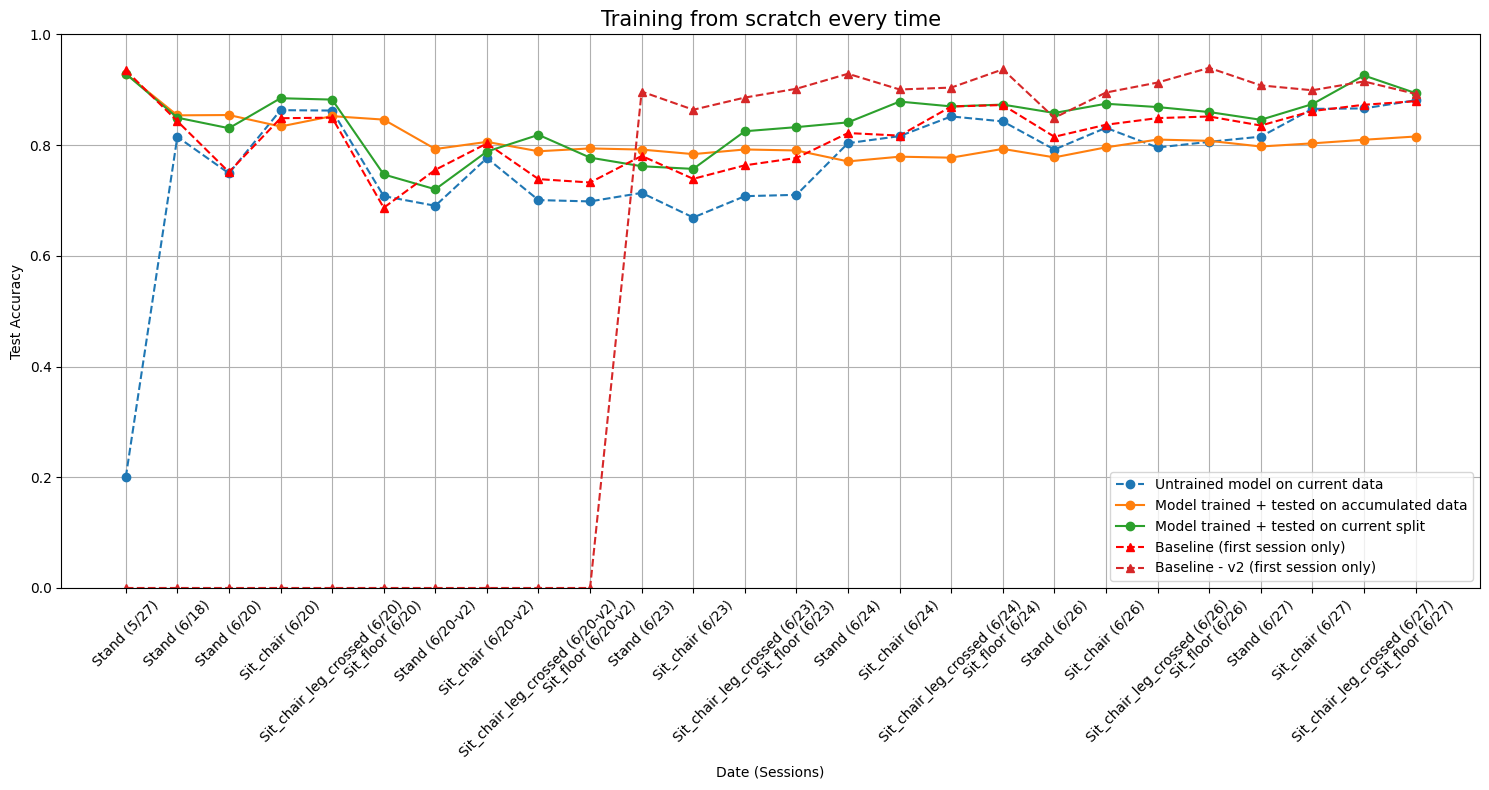

Average of acc without training this data (init; unseen): 76.27%
Average of acc using previous test data after training: 84.10%
Average of acc using current test data after training: 80.94%


In [2]:
if __name__ == "__main__":
    baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv'
    baseline2_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_10data.csv'

    cl_trainer = ContinualLearningTrainer(config)
    Init_acc_all, Prev_acc_all, Trained_acc_all = cl_trainer.run()
    cl_trainer.plot_results(baseline1_csv_path, baseline2_csv_path)

    for idx, x in enumerate([Init_acc_all, Prev_acc_all, Trained_acc_all]):
        if idx==0:
            print(f"Average of acc without training this data (init; unseen): {np.mean(x)*100:.2f}%")
        elif idx==1:
            print(f"Average of acc using previous test data after training: {np.mean(x)*100:.2f}%")
        elif idx==2:
            print(f"Average of acc using current test data after training: {np.mean(x)*100:.2f}%")